# Contd. - Strava-like Hotspot Analysis in Salzburg

For this assignment, I reused some elements from A3, where I had worked on a Strava-style activity dataset for Salzburg. This time, I modularized the code into a `.py` script with reusable functions, and added new geospatial functionality like activity grids, KDE density estimation, and buffer analysis. I also aimed to keep the workflow intuitive and build on what I learned last time.

The dataset includes synthetic activity points with columns:
- `location`
- `activity_type`
- `duration_min`
- `lat` and `lon`

Below, I walk through each step of the analysis using the functions I created in `geo_utils.py`


**Import libraries**

Uncomment these lines to install these packages if you don't have them installed!

In [ ]:
# !pip install geopandas folium contextily

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import contextily as ctx

from geo_utils import (
    load_geodata,
    tag_zones_by_duration,
    filter_by_activity,
    calculate_density,
    create_buffers,
    generate_activity_grid,
    compute_activity_stats_by_type
)


In [20]:
# load data
gdf = load_geodata("synthetic_strava_salzburg.csv")
gdf.head()

,location,activity_type,duration_min,lat,lon,geometry
0,Mirabell Gardens,Ride,22,47.806745,13.044416,POINT (13.04442 47.80675)
1,Mirabell Gardens,Walk,35,47.805793,13.044822,POINT (13.04482 47.80579)
2,Mirabell Gardens,Ride,43,47.806972,13.045866,POINT (13.04587 47.80697)
3,Mirabell Gardens,Walk,23,47.808285,13.045808,POINT (13.04581 47.80828)
4,Mirabell Gardens,Walk,31,47.805649,13.040945,POINT (13.04094 47.80565)


Now, I categorize each activity into:
- **Short** (<20 minutes)
- **Medium** (20–40 minutes)
- **Long** (>40 minutes)

This is done using the `tag_zones_by_duration()` function

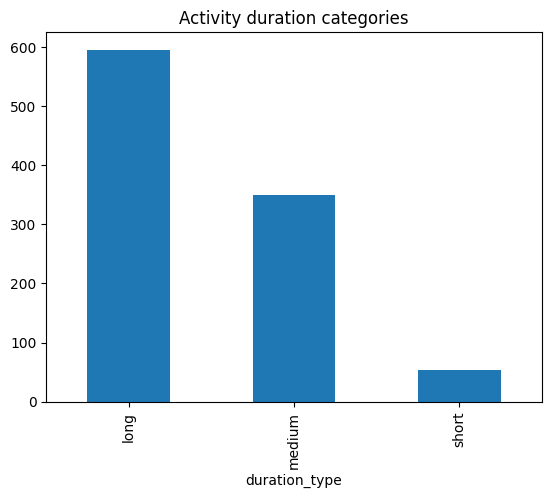

In [21]:
gdf = tag_zones_by_duration(gdf)
gdf["duration_type"].value_counts().plot(kind="bar", title="Activity duration categories")
plt.show()

As an example, I **filtered** the dataset to only show "Walk" activities using the `filter_by_activity()` function.
This lets me isolate specific patterns

In [22]:
walks = filter_by_activity(gdf, "Walk")
walks.head()

,location,activity_type,duration_min,lat,lon,geometry,duration_type
1,Mirabell Gardens,Walk,35,47.805793,13.044822,POINT (13.04482 47.80579),medium
3,Mirabell Gardens,Walk,23,47.808285,13.045808,POINT (13.04581 47.80828),medium
4,Mirabell Gardens,Walk,31,47.805649,13.040945,POINT (13.04094 47.80565),medium
6,Mirabell Gardens,Walk,48,47.808369,13.044730,POINT (13.04473 47.80837),long
15,Mirabell Gardens,Walk,57,47.805157,13.045218,POINT (13.04522 47.80516),long


Next, I use Folium to make an interactive heatmap of just the walking points. This shows where walks are clustered across Salzburg (AI use disclaimer: I use ChatGPT here for help with Folium)

In [23]:
walk_map = folium.Map(location=[47.8095, 13.0550], zoom_start=13, tiles="cartodbpositron")
walk_heat = [[row["lat"], row["lon"]] for _, row in walks.iterrows()]
HeatMap(walk_heat, radius=12, blur=15).add_to(walk_map)
walk_map

Here I use `generate_activity_grid()` to overlay a 250m fishnet grid over the city and count how many points fall into each cell - it helps visualize spatial density in a more structured way than scatterplots

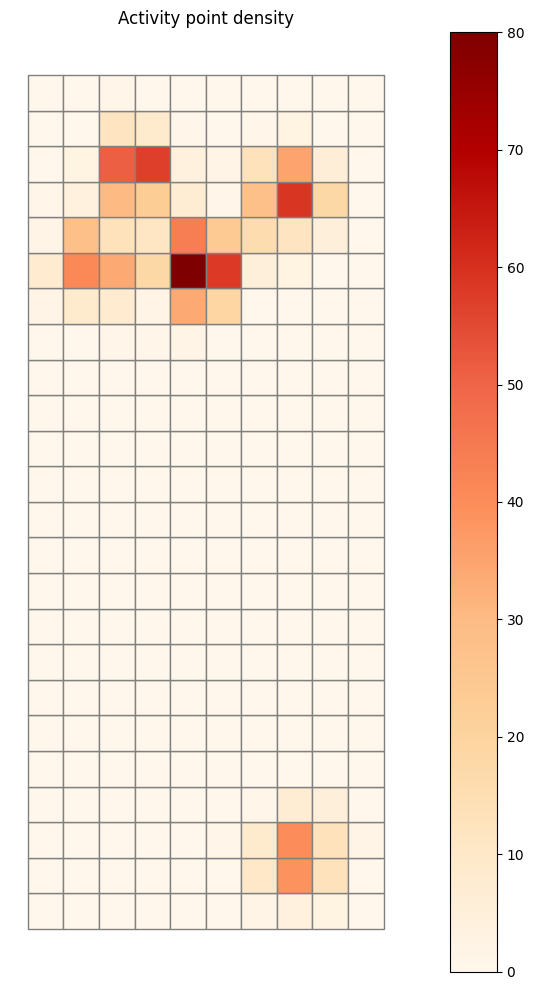

In [24]:
gdf_utm = gdf.to_crs("EPSG:32633")
grid = generate_activity_grid(gdf_utm, cell_size=250)

fig, ax = plt.subplots(figsize=(10, 10))
grid.plot(column="activity_count", cmap="OrRd", legend=True, edgecolor="grey", ax=ax)
plt.title("Activity point density")
plt.axis("off")
plt.tight_layout()
plt.show()

Summary stats by activity type

In [25]:
stats = compute_activity_stats_by_type(gdf)
stats

,count,mean,std,min,25%,50%,75%,max
activity_type,,,,,,,,
Hike,252.0,45.448413,15.771820,10.0,35.00,46.0,55.25,103.0
Ride,238.0,43.978992,14.638671,10.0,32.25,43.5,54.00,89.0
Run,270.0,45.355556,14.927068,10.0,34.00,44.0,55.00,85.0
Walk,240.0,43.412500,14.608154,10.0,34.00,44.0,53.00,84.0


kernel density estimation (KDE)

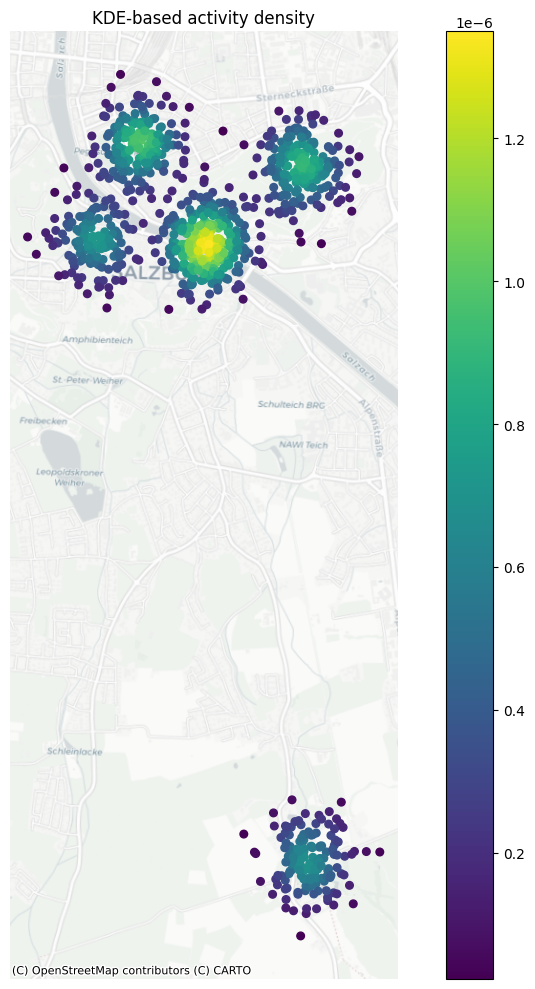

In [26]:
gdf_utm["density"] = calculate_density(gdf_utm)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_utm.plot(column="density", cmap="viridis", legend=True, markersize=30, ax=ax)
ctx.add_basemap(ax, crs=gdf_utm.crs, source=ctx.providers.CartoDB.Positron)
plt.title("KDE-based activity density")
plt.axis("off")
plt.tight_layout()
plt.show()

Create buffer zones

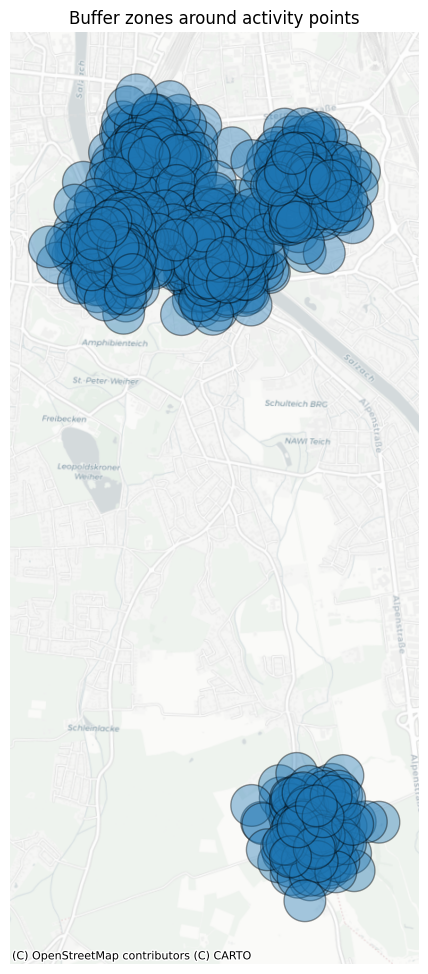

In [27]:
buffers = create_buffers(gdf, buffer_radius_m=150)

fig, ax = plt.subplots(figsize=(10, 10))
buffers.plot(alpha=0.4, edgecolor="k", ax=ax)
ctx.add_basemap(ax, crs=buffers.crs, source=ctx.providers.CartoDB.Positron)
plt.title("Buffer zones around activity points")
plt.axis("off")
plt.tight_layout()
plt.show()

I make another Folium map where the points are colored by duration type:
- Blue = short
- Orange = medium
- Red = long

I tried to add a legend directly to the map but ran into technical issues with Folium and HTML injection. (AI use disclaimer: I use ChatGPT here for help with Folium)


Hopefully the color coding still helps make the patterns easy to read!

In [28]:
color_map = {
    "short": "blue",
    "medium": "orange",
    "long": "red"
}
gdf["color"] = gdf["duration_type"].map(color_map)

dur_map = folium.Map(location=[47.8095, 13.0550], zoom_start=13, tiles="cartodbpositron")

for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=6,
        color=row["color"],
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['duration_type']} ({row['duration_min']} min)"
    ).add_to(dur_map)

dur_map